# CIFAR 10

## Libraries

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np

import seaborn as sns

from torchvision.datasets import CIFAR10


from ipywidgets import interact, interact_manual, interactive, fixed
import ipywidgets as widgets
from IPython.display import display

train_on_gpu = torch.cuda.is_available()
print(f"train_on_gpu = {train_on_gpu}")

train_on_gpu = True


## Load the data :D

In [0]:
# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
# choose the training and test datasets
train_data = CIFAR10('data', train=True,  download=True, transform=transform)
test_data  = CIFAR10('data', train=False, download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)

# percentage of training set to use as validation
valid_size = 0.15

split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]
print (f"num_train = {num_train}")

0it [00:00, ?it/s]

 99%|█████████▉| 168534016/170498071 [00:11<00:00, 33815946.85it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
num_train = 50000


In [0]:
batch_size = 20

# define samplers
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size, 
                                           sampler=train_sampler, 
                                           num_workers=0)

valid_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size, 
                                           sampler=valid_sampler, 
                                           num_workers=0)

test_loader = torch.utils.data.DataLoader(test_data, 
                                          batch_size=batch_size, 
                                          num_workers=0)

In [0]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## Show images

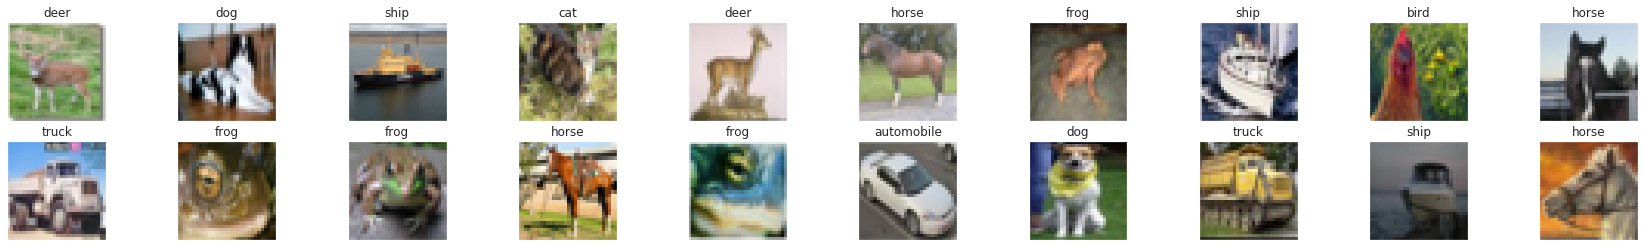

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

iterator_data = iter(train_loader)
images, labels = iterator_data.next()
images = images.numpy()

fig = plt.figure(figsize=(30, 4))

rows = 2
for i in np.arange(batch_size):
    ax = fig.add_subplot(rows, batch_size/rows, i+1, xticks=[], yticks=[])
    img = images[i] / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0))) 
    title = classes[labels[i]]
    ax.set_title(title)

In [0]:
def show_image(title, image, color = None):
  image = image / 2 + 0.5  # unnormalize
  plt.imshow(np.transpose(image, (1, 2, 0)))
  plt.axis("off")
  if color: plt.title(title, color=color)
  else: plt.title(title)


In [24]:
@interact(index = (0, 50000))
def show_image_dataset(index):
  img, label = train_data.__getitem__(index=index)
  title = classes[label]
  show_image(title, img)

interactive(children=(IntSlider(value=25000, description='index', max=50000), Output()), _dom_classes=('widget…

# Model

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 64, 5, padding=1)
        # convolutional layer (sees 64x64x64 tensor)
        self.conv2 = nn.Conv2d(64, 32, 5, padding=1)

        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # linear layer (72 * 4 * 4 -> 384)
        self.fc1 = nn.Linear(72 * 4 * 4, 384)
        # linear layer (384 -> 192)
        self.fc2 = nn.Linear(384, 192)
        # linear layer (192 -> 10)
        self.fc3 = nn.Linear(192, 10)

        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # flatten image input
        x = x.view(-1, 72 * 4 * 4)
        x = self.dropout(x)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        x = F.relu(self.fc2(x))
        x = self.dropout(x)

        x = F.relu(self.fc3(x))
        return x

    def evaluate(self, x):
      output = self(x)
      _, pred = torch.max(output, 1)  

      return pred


model = Net()
if train_on_gpu: model.cuda()

print(model)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=384, bias=True)
  (fc2): Linear(in_features=384, out_features=192, bias=True)
  (fc3): Linear(in_features=192, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.015)

# Train

In [13]:
n_epochs = 20
valid_loss_min = np.Inf

for epoch in range(1, n_epochs + 1):
    train_loss, valid_loss = 0.0, 0.0
    
    # train the model
    model.train()
    for data, target in train_loader:
        if train_on_gpu: data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)

        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        
    # validate the model
    model.eval()
    for data, target in valid_loader:
        if train_on_gpu:  data, target = data.cuda(), target.cuda()

        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item() * data.size(0)
    
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)

    print(f'Epoch: {epoch} \t', end="")        
    print(f'Training Loss: {np.round(train_loss, 6)} \t', end="")  
    print(f'Validation Loss: {np.round(valid_loss, 6)}')
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        before, after = np.round(valid_loss_min, 6), np.round(valid_loss, 6)
        print(f'Validation loss min: ({before} --> {after}). Saving model')

        torch.save(model.state_dict(), 'best_model_cifar.pt')
        valid_loss_min = valid_loss

    print()

Epoch: 1 	Training Loss: 1.391196 	Validation Loss: 1.251091
Validation loss min: (inf --> 1.251091). Saving model

Epoch: 2 	Training Loss: 1.247957 	Validation Loss: 1.136179
Validation loss min: (1.251091 --> 1.136179). Saving model

Epoch: 3 	Training Loss: 1.134779 	Validation Loss: 1.024412
Validation loss min: (1.136179 --> 1.024412). Saving model

Epoch: 4 	Training Loss: 1.042193 	Validation Loss: 1.018902
Validation loss min: (1.024412 --> 1.018902). Saving model

Epoch: 5 	Training Loss: 0.973767 	Validation Loss: 0.916657
Validation loss min: (1.018902 --> 0.916657). Saving model

Epoch: 6 	Training Loss: 0.907356 	Validation Loss: 0.879421
Validation loss min: (0.916657 --> 0.879421). Saving model

Epoch: 7 	Training Loss: 0.852376 	Validation Loss: 0.844123
Validation loss min: (0.879421 --> 0.844123). Saving model

Epoch: 8 	Training Loss: 0.809237 	Validation Loss: 0.836757
Validation loss min: (0.844123 --> 0.836757). Saving model

Epoch: 9 	Training Loss: 0.761606 	Va

In [14]:
model.load_state_dict(torch.load('best_model_cifar.pt'))

<All keys matched successfully>

# Test


In [0]:
def test_model(mode_name, mode_loader):
  mode_loss = 0.0
  class_correct = [0. for i in range(10)]
  class_total = [0. for i in range(10)]

  matrix_confusion_test = np.zeros((10, 10),  dtype=int)

  model.eval()
  for data, target in mode_loader:
      if train_on_gpu: data, target = data.cuda(), target.cuda()
      
      output = model(data)
      loss = criterion(output, target)
      mode_loss += loss.item() * data.size(0)

      # convert output probabilities to predicted class
      _, pred = torch.max(output, 1)    

      # compare predictions to true label
      targets_vals = target.data.view_as(pred)
      correct_tensor = pred.eq(targets_vals)
      correct = correct_tensor.numpy() if not train_on_gpu else correct_tensor.cpu().numpy()
      correct = np.squeeze(correct)
      
      # calculate test accuracy for each object class
      for i in range(batch_size):
          label = target.data[i]
          prediction = pred[i]

          class_correct[label] += correct[i].item()
          class_total[label] += 1

          matrix_confusion_test[label][prediction] += 1

  # average test loss
  mode_loss = mode_loss/len(test_loader.dataset)
  print(f'Test Loss: {np.round(mode_loss, 6)}')

  for i, class_name in enumerate(classes):
      if class_total[i] > 0:
          percentage = int(100 * class_correct[i] / class_total[i])
          correct, total  = int(np.sum(class_correct[i])), int(np.sum(class_total[i]))
          print(f'{mode_name} Accuracy of {class_name}:  {percentage}% ({correct}/{total})')
      else:
          print(f'{mode_name} Accuracy of {class_name}: \t N/A (no training examples)')

  percentage = int(100. * np.sum(class_correct) / np.sum(class_total))
  correct, total  = int(np.sum(class_correct)), int(np.sum(class_total))

  print(f'\n{mode_name} Accuracy (Overall): {percentage}% ({correct}/{total})\n\n')

  print("Confusion Matrix")
  print(matrix_confusion_test)

  sns.set() 
  ax = sns.heatmap(matrix_confusion_test)



Test Loss: 0.714721
Test Accuracy of airplane:  83% (836/1000)
Test Accuracy of automobile:  87% (879/1000)
Test Accuracy of bird:  64% (644/1000)
Test Accuracy of cat:  61% (610/1000)
Test Accuracy of deer:  63% (632/1000)
Test Accuracy of dog:  70% (706/1000)
Test Accuracy of frog:  82% (827/1000)
Test Accuracy of horse:  81% (814/1000)
Test Accuracy of ship:  81% (816/1000)
Test Accuracy of truck:  82% (820/1000)

Test Accuracy (Overall): 75% (7584/10000)


Confusion Matrix
[[836  19  23  25  10  12  11  11  31  22]
 [ 10 879   3   6   3   5   9   3  15  67]
 [ 68   6 644  66  49  69  53  30   6   9]
 [ 21   4  50 610  45 180  46  24   6  14]
 [ 17   2  65  88 632  63  46  75   7   5]
 [  8   2  30 170  23 706   7  46   2   6]
 [  5   3  34  80  18  25 827   5   1   2]
 [  9   1  17  42  39  62   5 814   2   9]
 [ 67  30  10  29   3   8   2   3 816  32]
 [ 30  84   6  15   0  10   7  12  16 820]]


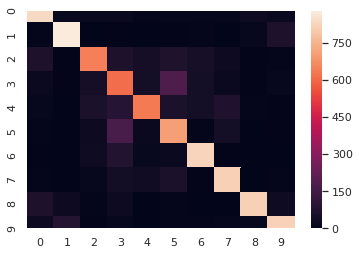

In [16]:
test_model("Test", test_loader)

Test Loss: 1.301114
Train Accuracy of airplane:  94% (4012/4235)
Train Accuracy of automobile:  97% (4125/4221)
Train Accuracy of bird:  84% (3587/4268)
Train Accuracy of cat:  83% (3579/4273)
Train Accuracy of deer:  87% (3684/4232)
Train Accuracy of dog:  86% (3685/4240)
Train Accuracy of frog:  93% (3994/4290)
Train Accuracy of horse:  94% (3999/4246)
Train Accuracy of ship:  93% (3975/4230)
Train Accuracy of truck:  95% (4060/4265)

Train Accuracy (Overall): 91% (38700/42500)


Confusion Matrix
[[4012   20   29   38   13   13    5    7   52   46]
 [  10 4125    0    6    1    4    5    8   10   52]
 [ 153    6 3587  151  107  122   95   33    2   12]
 [  27    2   57 3579   40  472   53   35    6    2]
 [  31    0   85  141 3684  115   50  122    2    2]
 [   9    1   29  393   37 3685   14   64    0    8]
 [   7    7   54  138   24   58 3994    4    1    3]
 [   3    1   21   68   32  111    5 3999    1    5]
 [ 114   49    9   22    2   14    5    1 3975   39]
 [  29  118    6   

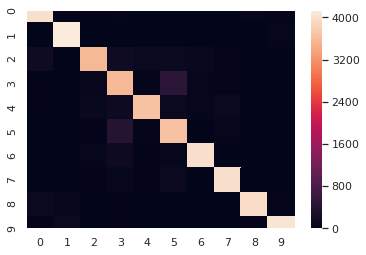

In [17]:
test_model("Train", train_loader)

#View result

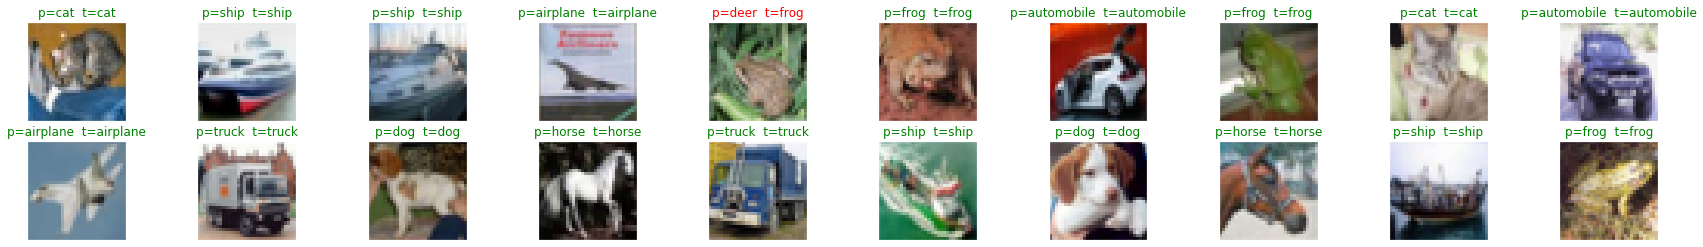

In [18]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

if train_on_gpu: images = images.cuda()
output = model(images)

_, preds_tensor = torch.max(output, 1)
preds = preds_tensor.numpy() if not train_on_gpu else preds_tensor.cpu().numpy()
preds = np.squeeze(preds)

# plot the images in the batch, with predicted and true labels

fig = plt.figure(figsize=(30, 4))
rows = 2
for i in np.arange(batch_size):
    ax = fig.add_subplot(rows, batch_size/rows, i+1, xticks=[], yticks=[])
    img = images.cpu()[i] / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))

    color = ("green" if preds[i]==labels[i].item() else "red")
    ax.set_title(f'p={classes[preds[i]]}  t={classes[labels[i]]}', color=color)

In [19]:
@interact(index = (0, 10000))
def show_image_dataset(index):
  raw_img, expected = test_data.__getitem__(index=index)

  image_as_expected = raw_img[None].type('torch.cuda.FloatTensor')
  prediction = model.evaluate(image_as_expected).tolist()[0]

  color = ("green" if prediction == expected else "red")
  title = f"prediction={classes[prediction]}   expected={classes[expected]}"

  show_image(title, raw_img, color)

interactive(children=(IntSlider(value=5000, description='index', max=10000), Output()), _dom_classes=('widget-…

In [0]:
def plot_filters_multi_channel(t):
    #get the number of kernals
    num_kernels = t.shape[0]    
    
    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = num_kernels
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    #looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].cpu().numpy(), np.float32)
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    plt.tight_layout()
    plt.show()

In [0]:
def plot_weights(model, layer_num, single_channel = True):
  
  #extracting the model features at the particular layer number
  layer = list(model.modules())[layer_num]
  
  #checking whether the layer is convolution layer or not 
  if isinstance(layer, nn.Conv2d) and layer.weight.data.shape[1] == 3:
      plot_filters_multi_channel(layer.weight.data)
        

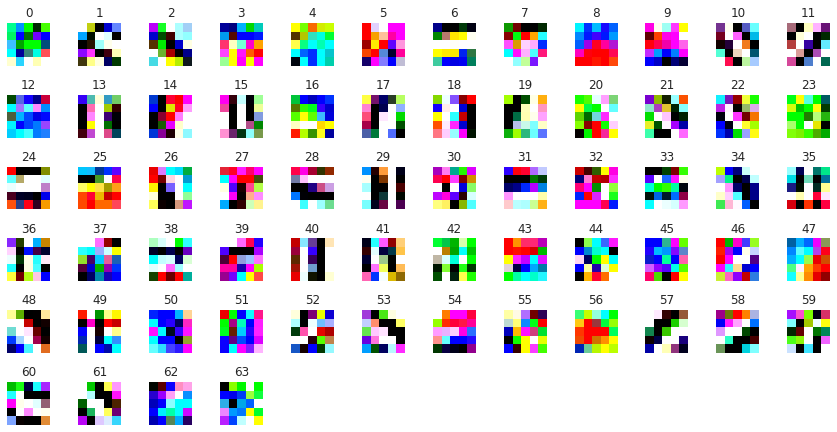

In [22]:
plot_weights(model, 1, single_channel = False)